In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

Here we create the test_model function that takes inputs the hyperparmaters of the model and runs the model

In [8]:
def test_model(episodes_num, runs_num, architecture, learning_rate, memory_size, batch_size, epsilon, update_net_freq):


    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(runs_num):
        print(f"Starting run {run+1} of {runs_num}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(memory_size)

        steps_done = 0

        episode_durations = []

        for i_episode in range(episodes_num):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episodes_num)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            #if run > 4 :
            #    epsilon *= 0.999
            #epsilon = ((11 - (2 * run) - 1) / 10)

            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_net_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

Find optimal architecture given a fixed epsilon=0.35, memory_size=20000, batch_size=1000, learning_rate=0.01, update_net_freq=1

In [13]:
architectures = [[4,4,16,2], [4,16,16,2], [4,16,32,2],[4,32,32,2],[4,32,64,2],[4,64,64,2]]

#SAVE THIS VARIABLE USING PICKLE
architecture_results = []

for architecture in architectures:
    architecture_results.append(test_model(episodes_num=300, runs_num=10, architecture=architecture, learning_rate=0.01, memory_size=20000, batch_size=1000, epsilon=0.35, update_net_freq=1))



Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

Plot of average mean return with varying architecture + best architecture detected

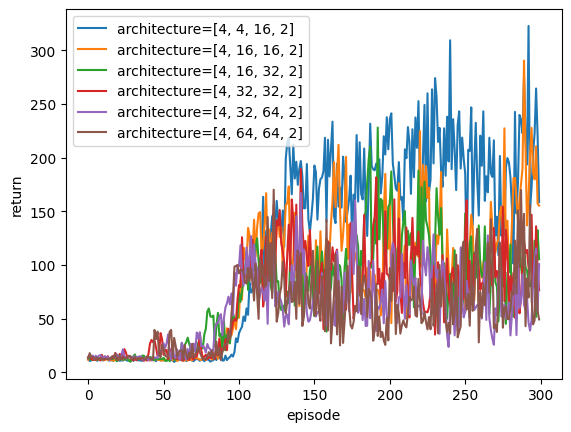

[4, 4, 16, 2]

In [18]:
legends = []
max_val = -float("inf")
best_architecture_results = None
best_architecture = None
for idx, architecture in enumerate(architecture_results):
    results = torch.tensor(architecture)
    means = results.float().mean(0)
    if torch.mean(means[200:]) > max_val:
        best_architecture_results = architecture
        max_val = torch.mean(means[200:])
        best_architecture = architectures[idx]
    legend = f"architecture={architectures[idx]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)

plt.legend(legends)
plt.ylabel("return")
plt.xlabel("episode")
plt.show()
best_architecture

Save the results

In [19]:
import pickle

file_name = "architecture_parameter.pkl"

variables = {"best_architecture" : best_architecture, "best_architecture_results" : best_architecture_results, "architecture_results" : architecture_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

Find optimal (memory_size, batch_size) pair given fixed espilon=0.32, architecture=best_architecture, learning_rate=0.01, update_net_freq=1

In [ ]:
memory_sizes = [1000, 5000, 10000, 15000, 20000, 30000]
batch_sizes = [[0.01, 0.03, 0.05]] * len(memory_sizes)


#SAVE THIS VARIABLE USING PICKLE
memory_batch_size_results = []

for idx, memory_size in enumerate(memory_sizes):
    for i in range(3):
        batch_size = batch_sizes[idx][i]
        memory_batch_size_results.append(test_model(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=0.01, memory_size=memory_size, batch_size=batch_size, epsilon=0.35, update_net_freq=1))
        


Plot of average mean return with varying memory and batch size pair + best values detected

In [ ]:
legends = []
max_val = -float("inf")
best_memory_batch_size_results = None
best_memory_batch_size = None
for idx, experiment in enumerate(memory_batch_size_results):
    results = torch.tensor(experiment)
    means = results.float().mean(0)
    if torch.mean(means[200:]) > max_val:
        best_memory_batch_size_results = experiment
        best_memory_batch_size = [memory_sizes[idx // 3], batch_sizes[idx % 3]]
    legend = f"memory={memory_sizes[idx // 3]}, batch={batch_sizes[idx % 3]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)

plt.legend(legends)
plt.ylabel("return")
plt.xlabel("episode")
plt.show()

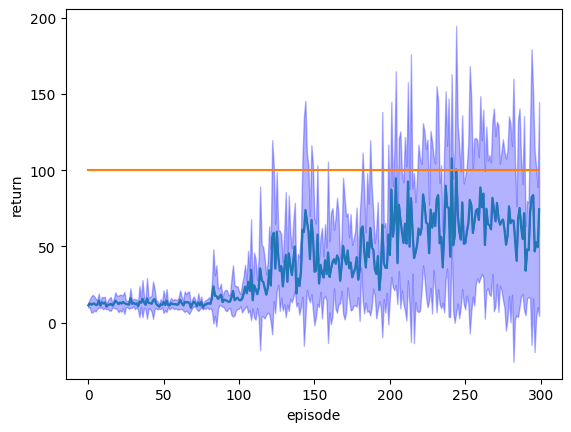

In [6]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)
constant = [100] * 300
plt.plot(torch.arange(300), means)
plt.plot(torch.arange(300), constant)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()